In [1]:
import os
import sys
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [33]:
def print_overview(merger):
    check_df = merger.df["details"].copy()
    check_df["additional.infected_7"] = check_df["cumulated.infected"]-check_df["cumulated.infected"].shift(periods=7)
    check_df["incidence"] = check_df["additional.infected_7"]/9660350*100000
    prv_active = check_df[-2:-1]["active.infected"].mean()
    act_active = check_df[-1:]["active.infected"].mean()
    print("Delta active infected:", act_active-prv_active)
    act_new = check_df[-1:]["additional.infected"].mean()
    act_deaths = check_df[-1:]["additional.deaths"].mean()
    prv_recover = check_df[-2:-1]["cumulated.recoveredFromHospital"].mean()
    act_recover = check_df[-1:]["cumulated.recoveredFromHospital"].mean()
    print("New infected - delta deaths - delta all recover:", act_new-act_deaths-(act_recover-prv_recover))
    return check_df[[
        "date", 
        "additional.infected",
        "cumulated.infected",
        "additional.infected_7",
        "incidence"
    ]].tail(20)

In [36]:
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)

Delta active infected: -3450.0
New infected - delta deaths - delta all recover: -3450.0


,date,additional.infected,cumulated.infected,additional.infected_7,incidence
431,2021-05-11,493.0,792879,8042.0,83.247501
432,2021-05-12,905.0,793784,7817.0,80.918393
433,2021-05-13,1416.0,795200,7553.0,78.185573
434,2021-05-14,1190.0,796390,7202.0,74.552164
435,2021-05-15,1039.0,797429,6865.0,71.063678
436,2021-05-16,718.0,798147,6438.0,66.643548
437,2021-05-17,426.0,798573,6187.0,64.045299
438,2021-05-18,382.0,798955,6076.0,62.896272
439,2021-05-19,633.0,799588,5804.0,60.080639
440,2021-05-20,780.0,800368,5168.0,53.497027


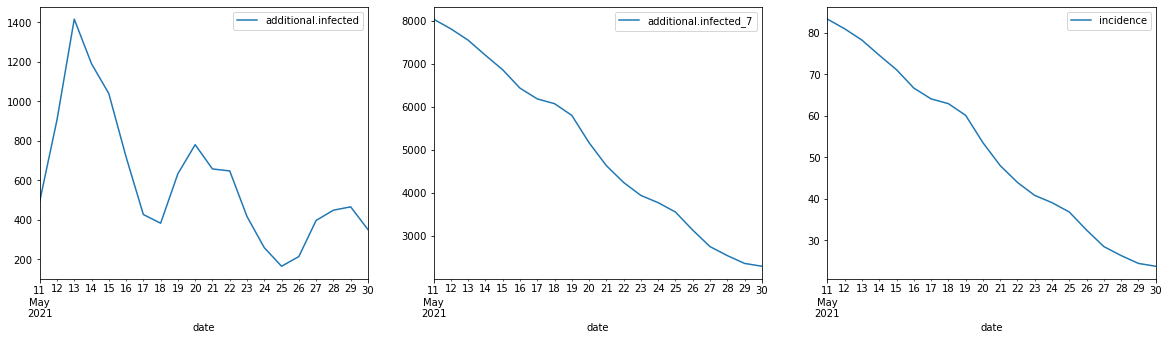

In [37]:
review_df = print_overview(merger)
fig, ax = plt.subplots(figsize=(20,5), ncols=3)
review_df.plot(x="date", y="additional.infected", ax=ax[0])
review_df.plot(x="date", y="additional.infected_7", ax=ax[1])
review_df.plot(x="date", y="incidence", ax=ax[2])
review_df

In [38]:
# merger.convert_deaths_df()
df = merger.merge_deaths_df()

In [39]:
df_additional = merger.df["details"][["date","additional.infected"]].set_index("date")

In [40]:
df_tests = merger.show_kpi_hu()[["tests"]].reset_index()
df_tests["index"] = pd.to_datetime(df_tests["index"], format='%Y-%m-%d').dt.date
df_tests["additional.tests"] = df_tests.apply(
    lambda row: row["tests"]-df_tests[
        df_tests["index"]==row["index"] - pd.Timedelta(1, unit='D')
    ]["tests"].max(), 
    axis=1
)
df_tests = df_tests.set_index("index")

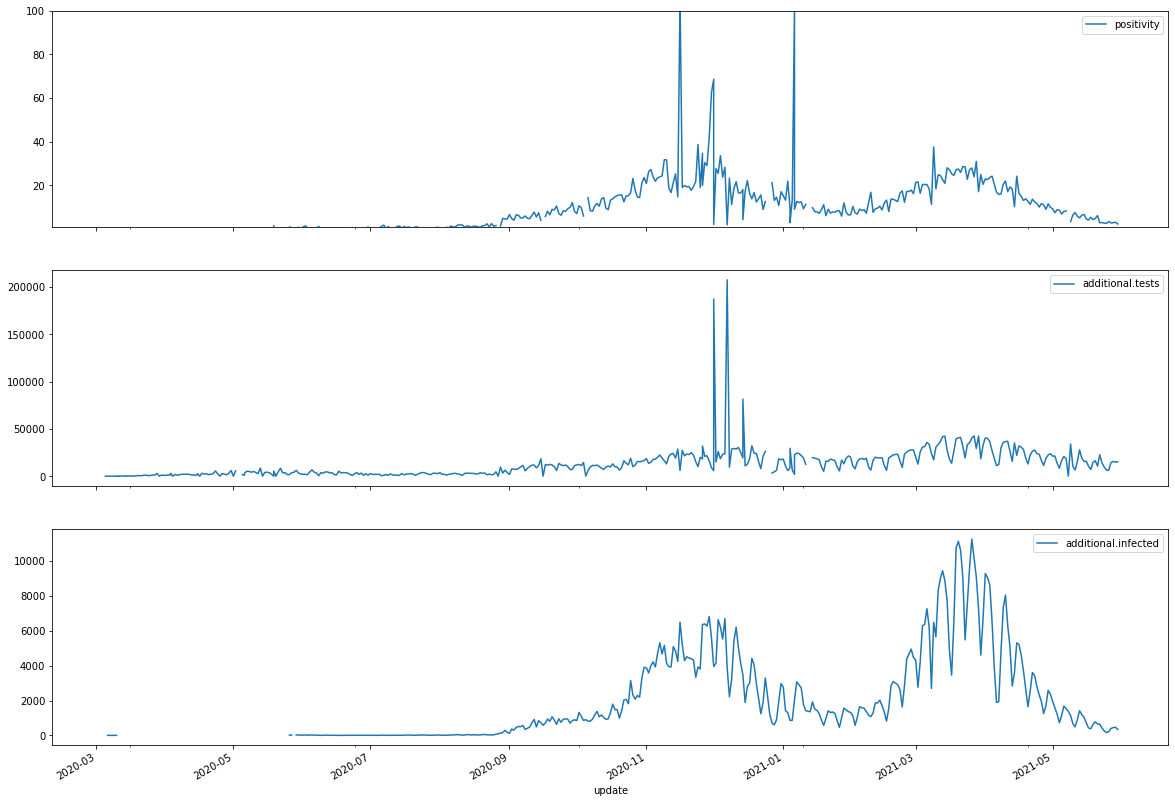

In [41]:
df_join = df_tests.join(df_additional).reset_index()
df_join["positivity"] = df_join["additional.infected"]/df_join["additional.tests"]*100
df_join["Country/Region"] = "HU"
df_join["update"] = df_join["index"]
(fig, ax) = plt.subplots(figsize=(20,15), nrows=3, sharex=True)
ax[0].set_ylim(1,100)
df_join.plot(x="update", y="positivity", ax=ax[0])
df_join.plot(x="update", y="additional.tests", ax=ax[1])
df_join.plot(x="update", y="additional.infected", ax=ax[2])
plt.show()

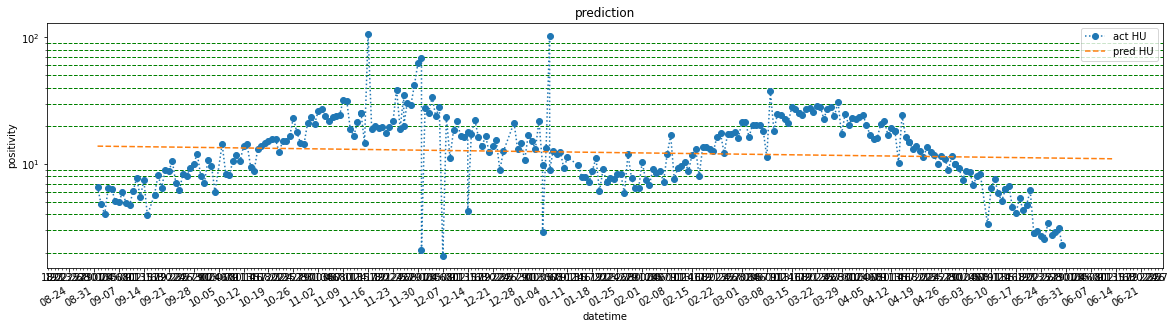

Coefficient of determination: {'HU': 0.009204490966282841}
Evolution factor per day: {'HU': 1.0}
Doubling in day(s): {'HU': 2.0}


,index,tests,additional.tests,additional.infected,positivity,Country/Region,update
494,2021-05-26,5756599.0,6240.0,213.0,3.413462,HU,2021-05-26
495,2021-05-27,5771058.0,14459.0,396.0,2.738779,HU,2021-05-27
496,2021-05-28,5786609.0,15551.0,448.0,2.880844,HU,2021-05-28
497,2021-05-29,5801554.0,14945.0,465.0,3.111408,HU,2021-05-29
498,2021-05-30,5816796.0,15242.0,350.0,2.296287,HU,2021-05-30


In [42]:
tmpDf = md.DataProcessing.Analyse.start_analyse(
    df_join[
        (df_join["additional.tests"]>0) & (df_join["index"]>=pd.Timestamp("2020-09-01"))
    ].dropna(),
    ["HU"],
    "positivity", 
    "positivity"
)
df_join.tail()

# Check plausibility

In [43]:
# Details
selected_details_df = merger.df["details"][[
    "date", "additional.infected", "additional.deaths", 
    "cumulated.infected", "cumulated.recoveredFromHospital", 
    "onVentilator", "hospital", "active.infected"
]].copy()
selected_details_df.columns = [
    "date", "news.add.infected", "news.add.deaths", 
    "news.cum.infected", "news.cum.recovered", 
    "news.onVentilator", "news.hospital", "news.active"
]
selected_details_df["date"] = pd.to_datetime(selected_details_df["date"], format='%Y-%m-%d').dt.date
selected_details_df["news.add.recovered"] = selected_details_df.apply(
    lambda row: row["news.cum.recovered"] - selected_details_df[
        selected_details_df["date"]<row["date"]
    ]["news.cum.recovered"].max(), axis=1
)
selected_details_df = selected_details_df.set_index("date")

# KPI
selected_kpi_df = merger.show_kpi_hu()[["infected"]].copy().reset_index()
selected_kpi_df.columns = ["date", "kpi.cum.infected"]
selected_kpi_df["date"] = pd.to_datetime(selected_kpi_df["date"], format='%Y-%m-%d').dt.date
selected_kpi_df = selected_kpi_df.set_index("date")

selected_details_df.join(selected_kpi_df).tail()

,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,kpi.cum.infected
date,,,,,,,,,
2021-05-26,213.0,41.0,802723,675082.0,148.0,1373.0,98019.0,3690.0,802723.0
2021-05-27,396.0,32.0,803119,682301.0,136.0,1215.0,91164.0,7219.0,803119.0
2021-05-28,448.0,28.0,803567,689166.0,121.0,999.0,84719.0,6865.0,803567.0
2021-05-29,465.0,27.0,804032,692248.0,114.0,1024.0,82075.0,3082.0,804032.0
2021-05-30,350.0,19.0,804382,696029.0,114.0,965.0,78625.0,3781.0,804382.0


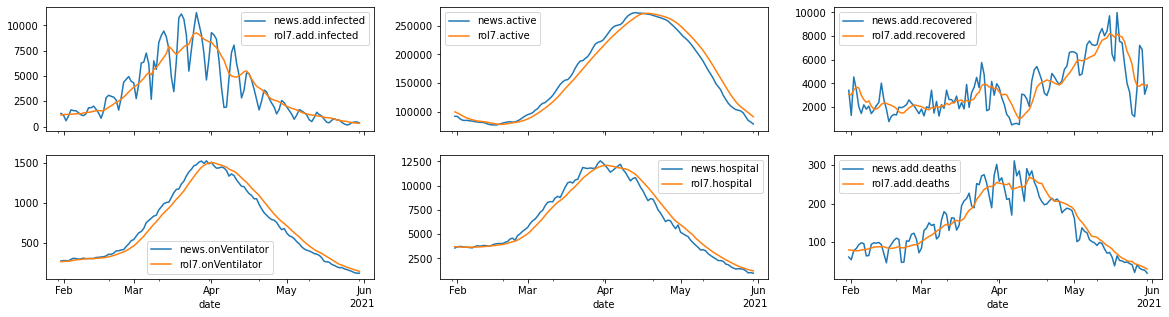

In [44]:
(fig, axs) = plt.subplots(figsize=(20,5), nrows=2, ncols=3, sharex=True)
plot_df = selected_details_df
configuration = {
    "add.infected":(0, 0), "onVentilator":(1,0),   # 1st col
    "active":(0,1),        "hospital":(1,1),       # 2nd col
    "add.recovered":(0,2), "add.deaths":(1,2)      # 3rd col
}
for category in configuration:
    plot_df["rol7.{}".format(category)] = plot_df.rolling(7).mean()[[f"news.{category}"]]
plot_df = plot_df.reset_index().tail(120)

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
for (category, position) in configuration.items():
    my_ax = axs[position[0]][position[1]]
    my_ax.xaxis.set_major_locator(locator)
    my_ax.xaxis.set_major_formatter(formatter)
    plot_df.plot(x="date", y="news.{}".format(category), ax=my_ax)
    plot_df.plot(x="date", y="rol7.{}".format(category), ax=my_ax)
plt.show()

In [45]:
#plot_df["add.infected"] = plot_df.apply(lambda row: plot_df[plot_df["date"]<], axis=1)
#plot_df.head()
plot_df.tail(10)

,date,news.add.infected,news.add.deaths,news.cum.infected,news.cum.recovered,news.onVentilator,news.hospital,news.active,news.add.recovered,rol7.add.infected,rol7.onVentilator,rol7.active,rol7.hospital,rol7.add.recovered,rol7.add.deaths
441,2021-05-21,657.0,47.0,801025,661564.0,195.0,1645.0,110034.0,5605.0,662.142857,244.142857,129642.571429,2081.142857,7524.714286,55.142857
442,2021-05-22,647.0,48.0,801672,665552.0,183.0,1500.0,106645.0,3988.0,606.142857,226.285714,123490.857143,1945.000000,6706.285714,51.571429
443,2021-05-23,416.0,44.0,802088,668820.0,185.0,1399.0,103749.0,3268.0,563.000000,215.428571,117757.285714,1820.571429,6247.428571,49.142857
444,2021-05-24,258.0,41.0,802346,670205.0,169.0,1420.0,102581.0,1385.0,539.000000,202.714286,112642.571429,1700.714286,5604.142857,49.571429
445,2021-05-25,164.0,21.0,802510,671392.0,159.0,1417.0,101537.0,1187.0,507.857143,189.571429,108760.142857,1589.285714,4346.857143,43.428571
446,2021-05-26,213.0,41.0,802723,675082.0,148.0,1373.0,98019.0,3690.0,447.857143,178.714286,105370.571429,1512.857143,3795.571429,41.857143
447,2021-05-27,396.0,32.0,803119,682301.0,136.0,1215.0,91164.0,7219.0,393.000000,167.857143,101961.285714,1424.142857,3763.142857,39.142857
448,2021-05-28,448.0,28.0,803567,689166.0,121.0,999.0,84719.0,6865.0,363.142857,157.285714,98344.857143,1331.857143,3943.142857,36.428571
449,2021-05-29,465.0,27.0,804032,692248.0,114.0,1024.0,82075.0,3082.0,337.142857,147.428571,94834.857143,1263.857143,3813.714286,33.428571
450,2021-05-30,350.0,19.0,804382,696029.0,114.0,965.0,78625.0,3781.0,327.714286,137.285714,91245.714286,1201.857143,3887.000000,29.857143


In [46]:
baseDf = pd.read_csv("data/map_data/map_dataframe_per_megye.csv", delimiter=",")[['date','region','confirmed']]
normDf = pd.read_csv("data/base/base_dataframe_per_megye.csv", delimiter=",")
baseDf = baseDf.merge(normDf, on="region")
# Convert date column and add week/dayofweek
baseDf["date"] =  pd.to_datetime(baseDf["date"], format="%Y-%m-%d")
baseDf["conf_per_100k"] = baseDf["confirmed"]/baseDf["population"]*100000
max_date = baseDf["date"].max()
date_list = [
    max_date - dt.timedelta(days=21),
    max_date - dt.timedelta(days=14),
    max_date - dt.timedelta(days=7),
    max_date
]
last_kpi = baseDf[baseDf["date"].isin(date_list)].pivot(
    index="region",
    columns="date",
    values="conf_per_100k"
)
last_kpi.columns = ["d-21", "d-14", "d-7", "d"]
last_kpi["w_2"] = last_kpi["d-14"] - last_kpi["d-21"]
last_kpi["w_1"] = last_kpi["d-7"] - last_kpi["d-14"]
last_kpi["w_0"] = last_kpi["d"] - last_kpi["d-7"]
last_kpi["+_1.5"] = last_kpi["w_1"] - last_kpi["w_2"]
last_kpi["+_0.5"] = last_kpi["w_0"] - last_kpi["w_1"]
last_kpi = last_kpi.join(normDf.set_index("region")[["population"]])
last_kpi["ok"] = 50
last_kpi["hum"] = 100
last_kpi["warning"] = 250
last_kpi["alert"] = 500

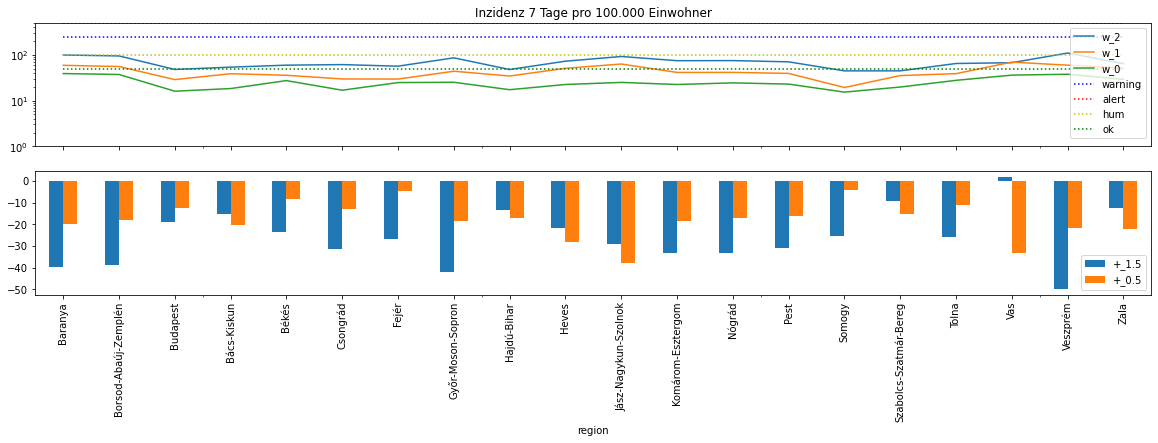

In [56]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,5), sharex=True)
ax[0].set_title("Inzidenz 7 Tage pro 100.000 Einwohner")
#> 500 – 1.000
#> 250 – 500
#> 100 – 250
#> 50 – 100
#> 25 – 50
#> 5 – 25
#> 0 – 5

last_kpi.plot.line(y=["w_2","w_1","w_0"], ax=ax[0])
last_kpi.plot.line(y=["warning","alert","hum","ok"], ax=ax[0], style=["b:","r:","y:","g:"])
last_kpi.plot.bar(y=["+_1.5","+_0.5"], ax=ax[1])
ax[0].set_ylim(1, 500)
ax[0].set_yscale("log")
plt.show()

In [48]:
last_kpi["time_serie"] = last_kpi.apply(
    lambda row: [
        row["d-14"]-row["d-21"], 
        row["d-7"]-row["d-14"], 
        row["d"]-row["d-7"]
    ], axis=1
)

def print_limits(ax, x1, x2):
    ax.add_patch(Rectangle((x1, 0), x2-x1, 5, linewidth=1, edgecolor='none', facecolor='#fffccd'))
    ax.add_patch(Rectangle((x1, 5), x2-x1, 20, linewidth=1, edgecolor='none', facecolor='#fff380'))
    ax.add_patch(Rectangle((x1, 25), x2-x1, 25, linewidth=1, edgecolor='none', facecolor='#ffb534'))
    ax.add_patch(Rectangle((x1, 50), x2-x1, 50, linewidth=1, edgecolor='none', facecolor='#d43624'))
    ax.add_patch(Rectangle((x1, 100), x2-x1, 150, linewidth=1, edgecolor='none', facecolor='#951214'))
    ax.add_patch(Rectangle((x1, 250), x2-x1, 250, linewidth=1, edgecolor='none', facecolor='#671212'))
    ax.add_patch(Rectangle((x1, 500), x2-x1, 500, linewidth=1, edgecolor='none', facecolor='#dd0085'))

['Baranya', 'Borsod-Abaúj-Zemplén', 'Budapest', 'Bács-Kiskun', 'Békés', 'Csongrád', 'Fejér', 'Győr-Moson-Sopron', 'Hajdú-Bihar', 'Heves', 'Jász-Nagykun-Szolnok', 'Komárom-Esztergom', 'Nógrád', 'Pest', 'Somogy', 'Szabolcs-Szatmár-Bereg', 'Tolna', 'Vas', 'Veszprém', 'Zala']


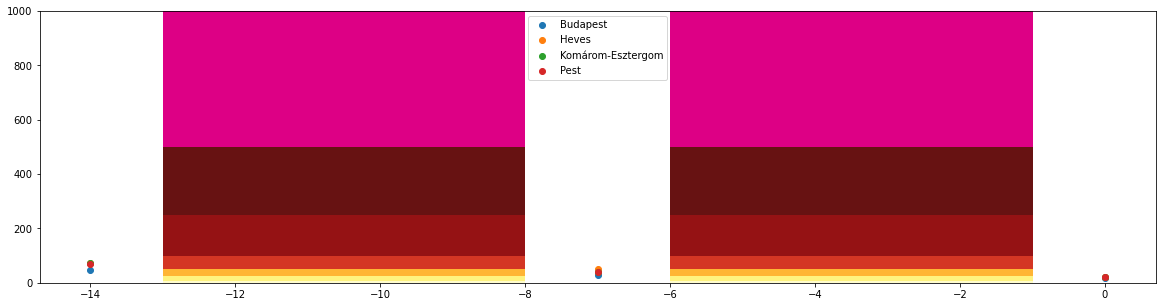

In [49]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(20,5))
print_limits(ax, -13, -8)
print_limits(ax, -6, -1)
print(list(last_kpi.index))
for region in list(last_kpi.index):
    if region in ["Heves", "Budapest", "Pest", "Komárom-Esztergom"]:
        ax.scatter(x=[-14,-7,0], y=last_kpi.loc[region]["time_serie"], cmap=plt.get_cmap("tab20"), label=region)
ax.set_ylim(0,1000)
ax.legend()
plt.show()

In [50]:
vaccinated_df = merger.df["details"][
    ["date","cumulated.vaccinated","cumulated.vaccinated2"]
].dropna()
vaccinated_df["additional.vaccinated"] = (
    vaccinated_df[["cumulated.vaccinated"]] - vaccinated_df[["cumulated.vaccinated"]].shift(periods=1)
)
vaccinated_df["additional.vaccinated2"] = (
    vaccinated_df[["cumulated.vaccinated2"]] - vaccinated_df[["cumulated.vaccinated2"]].shift(periods=1)
)
vaccinated_df["add.vaccinated_rol7"] = vaccinated_df.rolling(7).sum()[["additional.vaccinated"]]
vaccinated_df["add.vaccinated2_rol7"] = vaccinated_df.rolling(7).sum()[["additional.vaccinated2"]]
vaccinated_df["cumulated.vaccinated2_soll"] = vaccinated_df[["cumulated.vaccinated"]].shift(periods=28)
vaccinated_df[vaccinated_df["date"]<="2021-05-31"].tail()

,date,cumulated.vaccinated,cumulated.vaccinated2,additional.vaccinated,additional.vaccinated2,add.vaccinated_rol7,add.vaccinated2_rol7,cumulated.vaccinated2_soll
446,2021-05-26,5040222.0,3196604.0,13693.0,123664.0,249226.0,422188.0,3774221.0
447,2021-05-27,5056262.0,3328047.0,16040.0,131443.0,226667.0,513242.0,3870222.0
448,2021-05-28,5084642.0,3445557.0,28380.0,117510.0,185776.0,559265.0,3913550.0
449,2021-05-29,5120109.0,3539868.0,35467.0,94311.0,150788.0,572518.0,4023137.0
450,2021-05-30,5137031.0,3582547.0,16922.0,42679.0,131349.0,581558.0,4064204.0


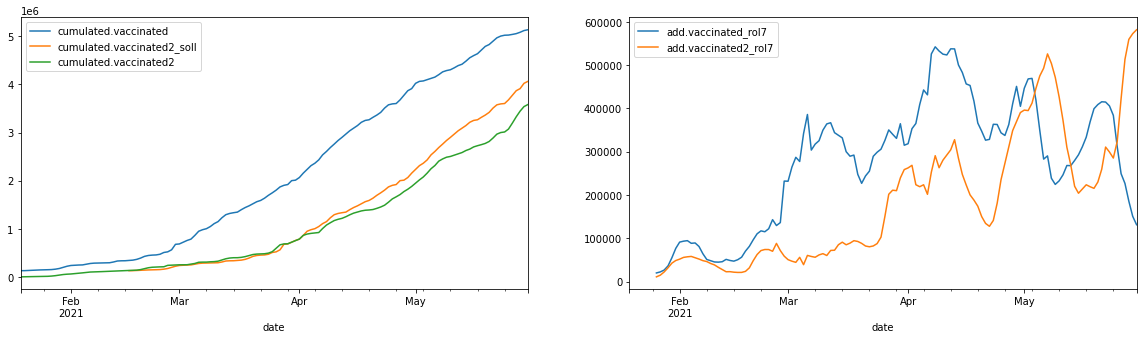

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
vaccinated_df.plot(x="date", y=[
    "cumulated.vaccinated","cumulated.vaccinated2_soll", "cumulated.vaccinated2"
], ax=ax[0])
vaccinated_df.plot(x="date", y=["add.vaccinated_rol7","add.vaccinated2_rol7"], ax=ax[1])
plt.show()

In [52]:
newBaseDf = baseDf.copy()
newBaseDf["date_7d"] = newBaseDf.apply(lambda row: row["date"] - dt.timedelta(days=7), axis=1)
newBaseDf["date_14d"] = newBaseDf.apply(lambda row: row["date"] - dt.timedelta(days=14), axis=1)
newBaseDf["confirmed_7d"] = newBaseDf.apply(
    lambda row: newBaseDf[
        (newBaseDf["date"]==row["date_7d"]) & (newBaseDf["region"]==row["region"])
    ]["confirmed"].max(), 
    axis=1
)
newBaseDf["confirmed_14d"] = newBaseDf.apply(
    lambda row: newBaseDf[
        (newBaseDf["date"]==row["date_14d"]) & (newBaseDf["region"]==row["region"])
    ]["confirmed"].max(), 
    axis=1
)
newBaseDf["incidence_0"] = (newBaseDf["confirmed"]-newBaseDf["confirmed_7d"])/newBaseDf["population"]*100000
newBaseDf["incidence_1"] = (newBaseDf["confirmed_7d"]-newBaseDf["confirmed_14d"])/newBaseDf["population"]*100000
newBaseDf["delta_incidence"] = newBaseDf["incidence_0"]-newBaseDf["incidence_1"]
newBaseDf = newBaseDf.dropna()

In [53]:
def plot_region(baseDf, region, axs, lims):
    conf_per_100k = baseDf[(baseDf["region"]==region)]["conf_per_100k"].max()
    if conf_per_100k>lims[3]:
        ax=0
        lim=f"[{lims[3]}-]"
    elif conf_per_100k>lims[2]:
        ax=1
        lim=f"[{lims[2]}-{lims[3]}]"
    elif conf_per_100k>lims[1]:
        ax=2
        lim=f"[{lims[1]}-{lims[2]}]"
    elif conf_per_100k>lims[0]:
        ax=3
        lim=f"[{lims[0]}-{lims[1]}]"
    else:
        ax=4
        lim=f"[-{lims[0]}]"
    title_0=f"incidence {lim}"
    title_1=f"conf_per_100k {lim}"
    title_2=f"delta_incidence {lim}"
    baseDf[(baseDf["region"]==region)].plot(
        x="date", y="incidence_0", ax=axs[ax][0], label=region, style=":"
    )
    baseDf[(baseDf["region"]==region)].plot(
        x="date", y="conf_per_100k", ax=axs[ax][1], label=region, style=":"
    )
    baseDf[(baseDf["region"]==region)].plot(
        x="date", y="delta_incidence", ax=axs[ax][2], label=region, style=":"
    )
    opening = pd.to_datetime('20210406', format='%Y%m%d', errors='ignore')
    axs[ax][0].legend(loc = "upper left").remove()
    axs[ax][0].set_ylim(0, 1000)
    axs[ax][0].plot((baseDf["date"].min(), baseDf["date"].max()), (250, 250), 'k-')
    axs[ax][0].plot((baseDf["date"].min(), baseDf["date"].max()), (500, 500), 'k-')
    axs[ax][0].plot((opening, opening), (250, 500), 'k-')
    axs[ax][0].set_title(title_0)
    axs[ax][1].legend(loc = "upper left")
    axs[ax][1].set_ylim(0, 20000)
    axs[ax][1].set_title(title_1)
    axs[ax][2].legend(loc = "upper left").remove()
    axs[ax][2].plot((opening, opening), (-100, 100), 'k-')
    axs[ax][2].plot((baseDf["date"].min(), baseDf["date"].max()), (0, 0), 'k-')
    axs[ax][2].set_title(title_2)

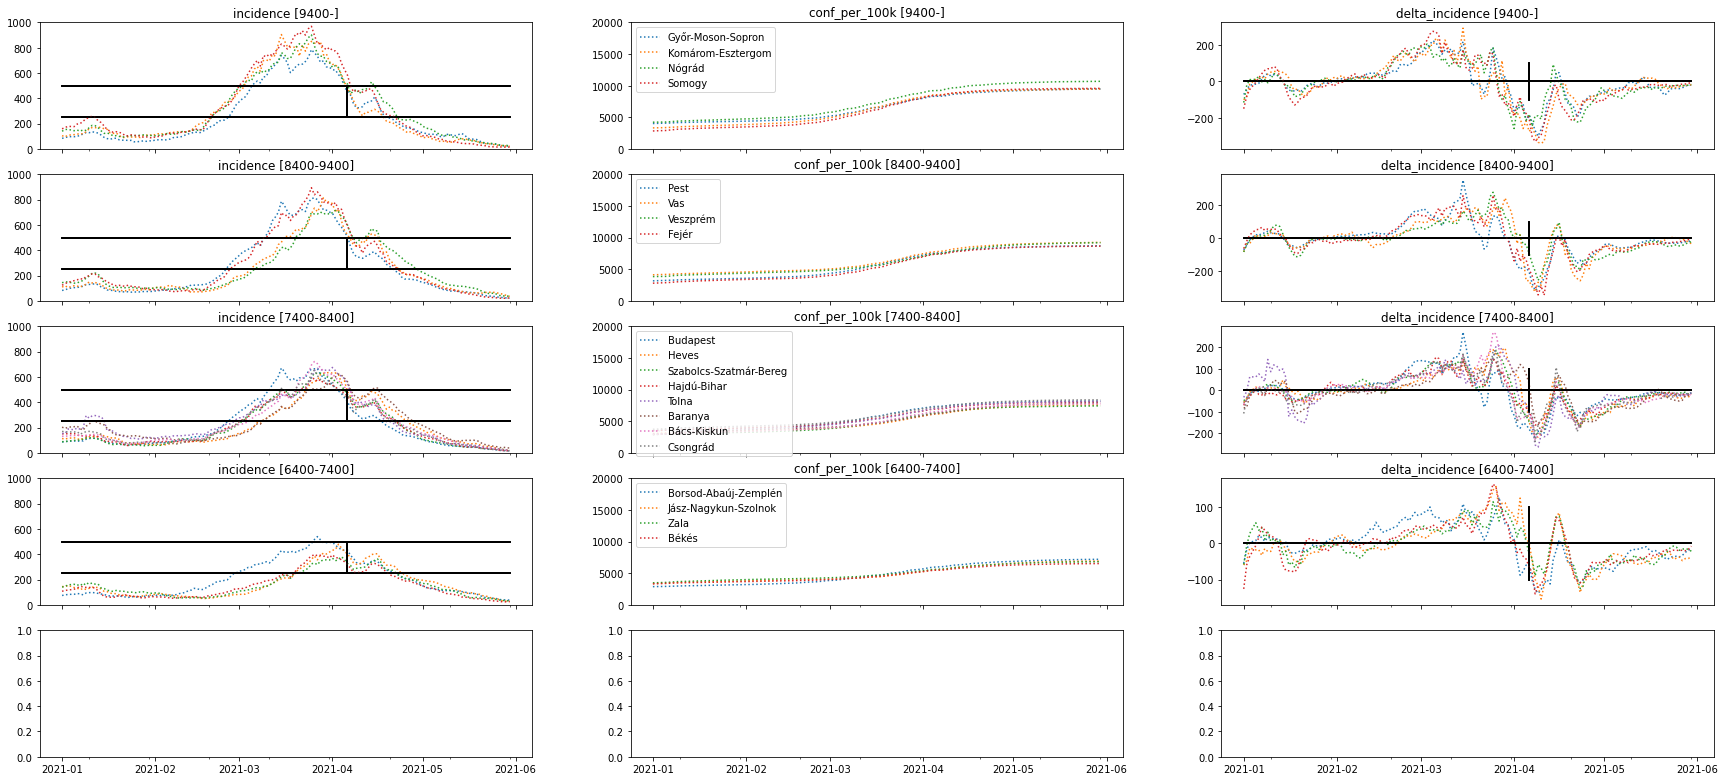

In [54]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(30,15), sharex=True)
lims = [6400,7400,8400,9400]
for region in newBaseDf["region"].unique():
    plot_region(newBaseDf[(newBaseDf["date"]>="2021-01-01")], region, ax, lims)
plt.show()

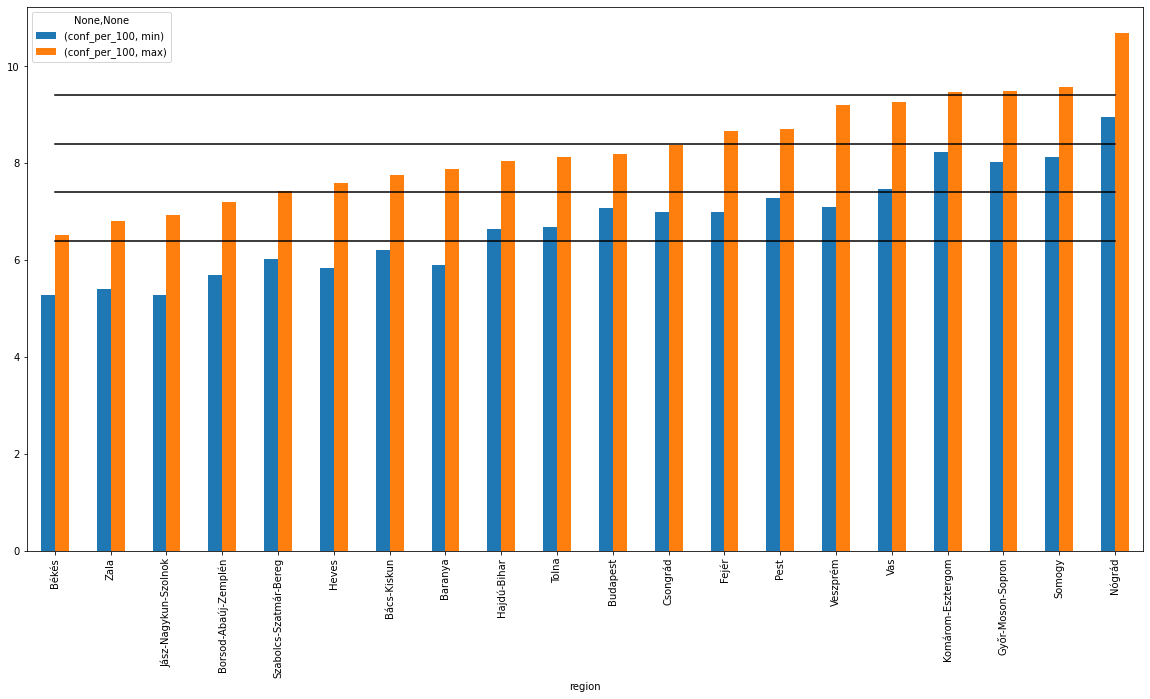

In [55]:
fig, ax = plt.subplots(figsize=(20,10))
for lim in lims:
    ax.plot((0, 19), (lim/1000, lim/1000), 'k-')
newBaseDf["conf_per_100"] = newBaseDf["conf_per_100k"]/1000
newBaseDf[(newBaseDf["date"]>="2021-04-01")].groupby(["region"]).agg(
    {"conf_per_100":["min","max"]}
).sort_values([("conf_per_100","max")]).plot.bar(ax=ax)
plt.show()